In [1]:
import numpy as np
import stan_jupyter as stan
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from gproc.generative import sample_at_x
from gproc.plotting import contour_2d
from gproc.kernels import *

## Bayesian Logistic Regression

In [2]:
N = 1500 # Data size
D = 2 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x 2 matrix
true_lengthscale = 1
true_variance = 1
kernel = SquaredExponential(lengthscale = true_lengthscale, variance = true_variance)

y, prob_y, f = sample_at_x(x, kernel)

# Let's do a test train split, leaving 200 points for testing
x, x_test, y, y_test = train_test_split(x, y, test_size = 0.2)

In [3]:
# Write a function to organise the data into stan friendly format

def stanvert(x, y):
    """
    Converts data to pystan friendly format

    :params X, N x d matrix, matrix of features
    :params Y, N vector, vector of responses
    
    :stan_data, dict, stan data dictionary
    """
    
    stany = np.zeros(y.shape[0])
    stany[:] = y
    
    # Set the -1's to 0's for stan
    stany[stany == -1] = 0

    # Prepare the data for stan; x = covariates, y = response, d = dimensions, n = sample size
    stan_data = {'x': x, 'y': stany.astype(int), 'd': x.shape[1], 'n': x.shape[0]}
    
    return stan_data

stan_data = stanvert(x, y)
stanvert(x, y)

{'x': array([[-0.73116639,  0.8793069 ],
        [-0.40370969,  0.59647199],
        [-0.53655327,  0.45847905],
        ...,
        [-0.3952967 , -0.56738258],
        [-0.18305592, -0.340591  ],
        [-0.86364984,  0.45717472]]),
 'y': array([1, 1, 1, ..., 0, 0, 0]),
 'd': 2,
 'n': 1200}

In [4]:
# Let's define the Bayesian Logistic Regression model in stan using a N(0, I) prior on all the parameters

blr_model = """
data {
  int<lower=0> n; // number of observations
  int<lower=0> d; // number of predictors
  array[n] int<lower=0,upper=1> y; // outputs
  matrix[n,d] x; // inputs
}
parameters {
  vector[d] theta; // auxiliary parameter
}
model {
  theta ~ normal(0, 1);
  vector[n] p = x * theta;
  y ~ bernoulli_logit(p);
}
"""

In [5]:
def posterior_sampler(stan_model, stan_data, num_chains, num_samples, num_warmup):
    """
    Uses pystan to sample from a posterior distribution 
    
    :param stan_model, string, stan model code
    :param stan_data, dict, stan data dictionary
    :param num_chains, int, number of chains to sample
    :param num_samples, int, number of samples per chain
    :param num_warmup, int, number of warmup samples per chain
    
    :returns fit, stan.fit.Fit, fitted stan model containing posterior samples
    """
    posterior = stan.build(stan_model, data = stan_data)
    fit = posterior.sample(num_chains = num_chains, num_samples = num_samples, num_warmup = num_warmup)
    return fit

fit = posterior_sampler(blr_model, stan_data, 1, 2500, 500)

Building: found in cache, done.
Sampling:   0%
Sampling:   3% (100/3000)
Sampling:  13% (400/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 9.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
  Adjust your expectations accordingly!


In [6]:
samples = fit['theta']

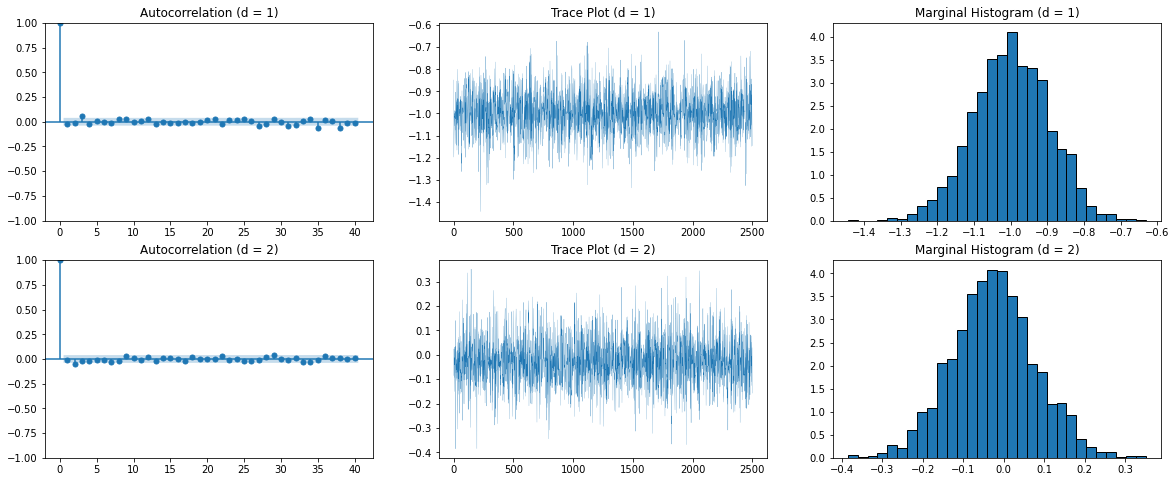

In [7]:
def inspect_samples(samples):
    """ 
    Plot the ACF, trace plots and marginal histograms of the posterior samples for each dimension
    
    :param samples, sample_size x d matrix, matrix of posterior samples  
    """
    d = samples.shape[1]
    fig, ax = plt.subplots(d, 3, figsize = (20, d*4))
    
    index = -1
    for i in range(d): 
        index += 1

        plot_acf(samples[:, i], lags = 40, ax = ax[index, 0])
        ax[index, 0].set_title(f'Autocorrelation (d = {i + 1})')
        ax[index, 1].plot(samples[:, i], linewidth = 0.2)
        ax[index, 1].set_title(f'Trace Plot (d = {i + 1})')
        ax[index, 2].hist(samples[:, i], density = True, bins = 30, ec = 'black')
        ax[index, 2].set_title(f'Marginal Histogram (d = {i + 1})')

    plt.show()

inspect_samples(samples.T)

In [8]:
from gproc.predictive_sampling import blr_predictive
from gproc.metrics import max_threshold, predictive_metrics, abstention_metrics, inspect_metrics

probs, preds, prob_ests, y_ests = blr_predictive(x_test, samples)
rhos = np.linspace(0, max_threshold(prob_ests), 1000)
cap_metrics = abstention_metrics(prob_ests, y_ests, y_test, rhos)

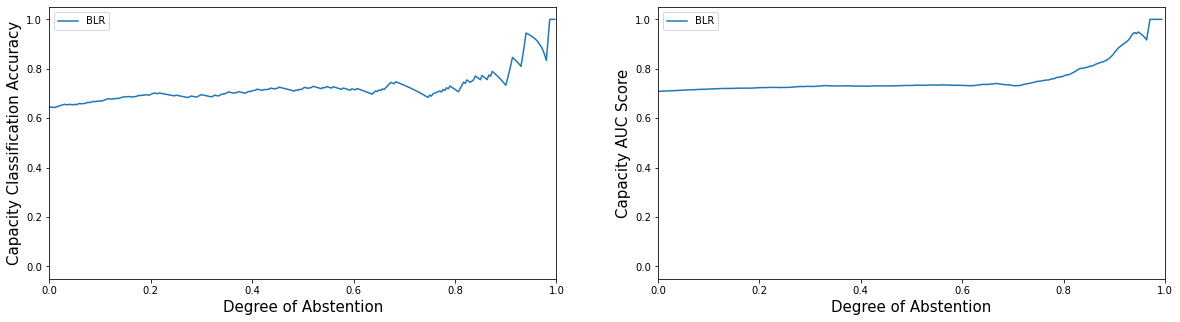

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

inspect_metrics(ax[0], ax[1], cap_metrics, label = 'BLR')